### Import the necessary dependencies

In [2]:
import subprocess
from pathlib import Path

import cv2
import shutil
import matplotlib.pyplot as plt
import yt_dlp
import torch
import torchvision
from IPython.display import Video
from torchvision import transforms
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from torchvision import datasets
from torch.utils.data import DataLoader

/root/Computer_vision-1/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check the version of dependencies
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("cv2 version : ", cv2.__version__)

!python --version

torch version :  2.2.2+cu121
torchvision version :  0.17.2+cu121
cv2 version :  4.11.0
Python 3.12.3


In [10]:
# check if cuda is available
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


### Download the video data from Youtube

For this project we would be using video from the the trevor noah what now? podcast. This particular video contains three faces we would be working with. The code below downloads the video.

In [10]:
video_name = "podcast.mp4"
video_url = "https://www.youtube.com/watch?v=lRBA74Yd6eo&list=PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_&index=5"

try:
    ydl_opts = {
        'outtmpl': video_name,
        'format': 'mp4/best',
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])
    print(f"Video downloaded successfully as '{video_name}'")
except Exception as e:
    print(f"An error occurred: {e}")

[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=lRBA74Yd6eo&list=PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_&index=5
[youtube:tab] Downloading playlist PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_ - add --no-playlist to download just the video lRBA74Yd6eo
[youtube:tab] PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_: Downloading webpage
[youtube:tab] Extracting URL: https://www.youtube.com/playlist?list=PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_
[youtube:tab] PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_: Downloading webpage
[youtube:tab] PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_: Redownloading playlist API JSON with unavailable videos
[download] Downloading playlist: What Now? With Trevor Noah - (Full Podcast Episodes)
[youtube:tab] PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_ page 1: Downloading API JSON


[youtube:tab] PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_ page 1: Downloading API JSON


[youtube:tab] PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_ page 1: Downloading API JSON


[youtube:tab] PLGLDEODaMX-uh8ZqttiSoV1d30dm9C5Y_ page 1: Downloading API JSON


[youtube:tab] Playlist What Now? With Trevor Noah - (Full Podcast Episodes): Downloading 23 items of 23
[download] Downloading item 1 of 23
[youtube] Extracting URL: https://www.youtube.com/watch?v=sS4a8vb6G94
[youtube] sS4a8vb6G94: Downloading webpage
[youtube] sS4a8vb6G94: Downloading tv player API JSON
[youtube] sS4a8vb6G94: Downloading ios player API JSON
[youtube] sS4a8vb6G94: Downloading m3u8 information
[info] sS4a8vb6G94: Downloading 1 format(s): 18
[download] Destination: podcast.mp4
[download] 100% of  132.46MiB in 00:00:42 at 3.10MiB/s   
[download] Downloading item 2 of 23
[youtube] Extracting URL: https://www.youtube.com/watch?v=pNDidttHP9M
[youtube] pNDidttHP9M: Downloading webpage
[youtube] pNDidttHP9M: Downloading tv player API JSON
[youtube] pNDidttHP9M: Downloading ios player API JSON
[youtube] pNDidttHP9M: Downloading m3u8 information
[info] pNDidttHP9M: Downloading 1 format(s): 18
[download] podcast.mp4 has already been downloaded
[download] 100% of  132.46MiB
[down

In [13]:
# Display the video
Video("podcast.mp4")

#### Let's create a data directory to save the the short 1 minute clip we would use to create the model embedding

In [16]:
data_dir = Path("data")

data_dir.mkdir(exist_ok=True)

In [29]:
# lets extract the first one minues of the video
def cut_video(input_file:str, output_file:str, start_time:float, duration:float) -> None:
    """
    Args:
    Cuts a portion of the video
    input_file: Path to the input video file
    output_file: Path to the output video file
    start_time: start time of the vido cut in sec
    duration of the video cut in seconds
    
    Return:
        None
    """
    
    command = [
        "ffmpeg",
        "-ss",
        str(start_time),
        "-i",
        input_file,
        "-t",
        duration,
        "-c",
        "copy",
        output_file
    ]
    
    subprocess.run(command)

In [26]:
# save the output file to the data directory
output_file = data_dir/ "output.mp4"
print(output_file)

data/output.mp4


In [34]:
output_file_short = data_dir / "output_short.mp4"

In [33]:
output_file_short_10 = data_dir / "output_short10sec.mp4"

In [28]:
start_time = "00:00:00"  # Start at 00 seconds
duration = "00:01:00"  # Cut 1 minute

cut_video("podcast.mp4", output_file, start_time, duration)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

In [30]:
start_time = "00:00:30"  # Start at 30 seconds
duration = "00:00:30"  # Cut 30 seconds

cut_video(output_file, output_file_short, start_time, duration)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

In [35]:
start_time = "00:00:40"  # Start at 30 seconds
duration = "00:00:10"  # Cut 30 seconds

cut_video(output_file, output_file_short_10, start_time, duration)

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

In [7]:
Video(output_file)

In [31]:
Video(output_file_short)

In [36]:
Video(output_file_short_10)

In [8]:
capture = cv2.VideoCapture(output_file)

if not capture.isOpened():
    print("Error: Could not open the file")
else:
    frame_rate = capture.get(cv2.CAP_PROP_FPS)
    frame_count = capture.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Frame rate: {frame_rate}")
    print(f"Total number of frame: {frame_count}")
    print("frames height : ", frame_height)
    print("frames width : ", frame_width)

Frame rate: 23.976023976023978
Total number of frame: 1439.0
frames height :  360
frames width :  640


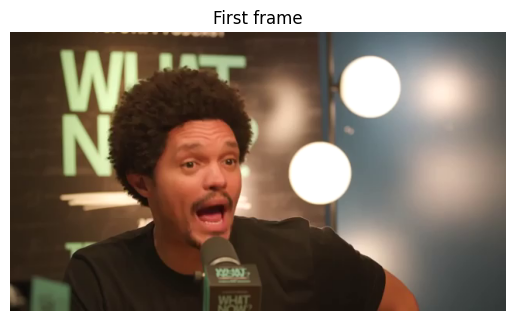

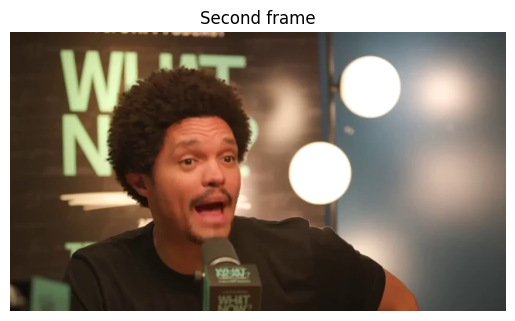

In [10]:
# display the first frame
res, first_frame = capture.read()

if res:
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("First frame")
    plt.axis("off")
    plt.show()
    res, second_frame = capture.read()
    
    if res:
        # Display the second frame
        plt.imshow(cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB))
        plt.title("Second frame")
        plt.axis("off")
        plt.show()
    else:
        print("Error: could not read second frame")
else:
    print("Error: could not read first frame")

### Extract frames from the video

In [18]:
frames_dir = data_dir / "extracted_frames"

frames_dir.mkdir(exist_ok=True)

In [48]:
interval = 4
frame_count = 0

print("Starting the frame extraction ....")
while True:
    ret , frame = capture.read()
    if not ret:
        print("Finished")
        break
    
    if frame_count % interval == 0:
        frame_path = frames_dir / f"frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)
        
    frame_count += 1
    
capture.release() 

Starting the frame extraction ....
Finished


In [12]:
# check the number of saved frames
number_of_frames = len(list(frames_dir.iterdir()))
number_of_frames

360

In [13]:
frames_dir

PosixPath('data/extracted_frames')

In [14]:
# lets see some sample from the extracted frames
def display_sample(dir_path, sample=3):
    image_list = []
    images = sorted(dir_path.iterdir())
    if images:
        sample_image = images[:sample]
        for img in sample_image:
            image = read_image(str(img))
            resize_transform = transforms.Resize((240, 240))
            image = resize_transform(image)
            image_list.append(image)
    grid = make_grid(image_list, nrow=5)
    image = to_pil_image(grid)
    return image

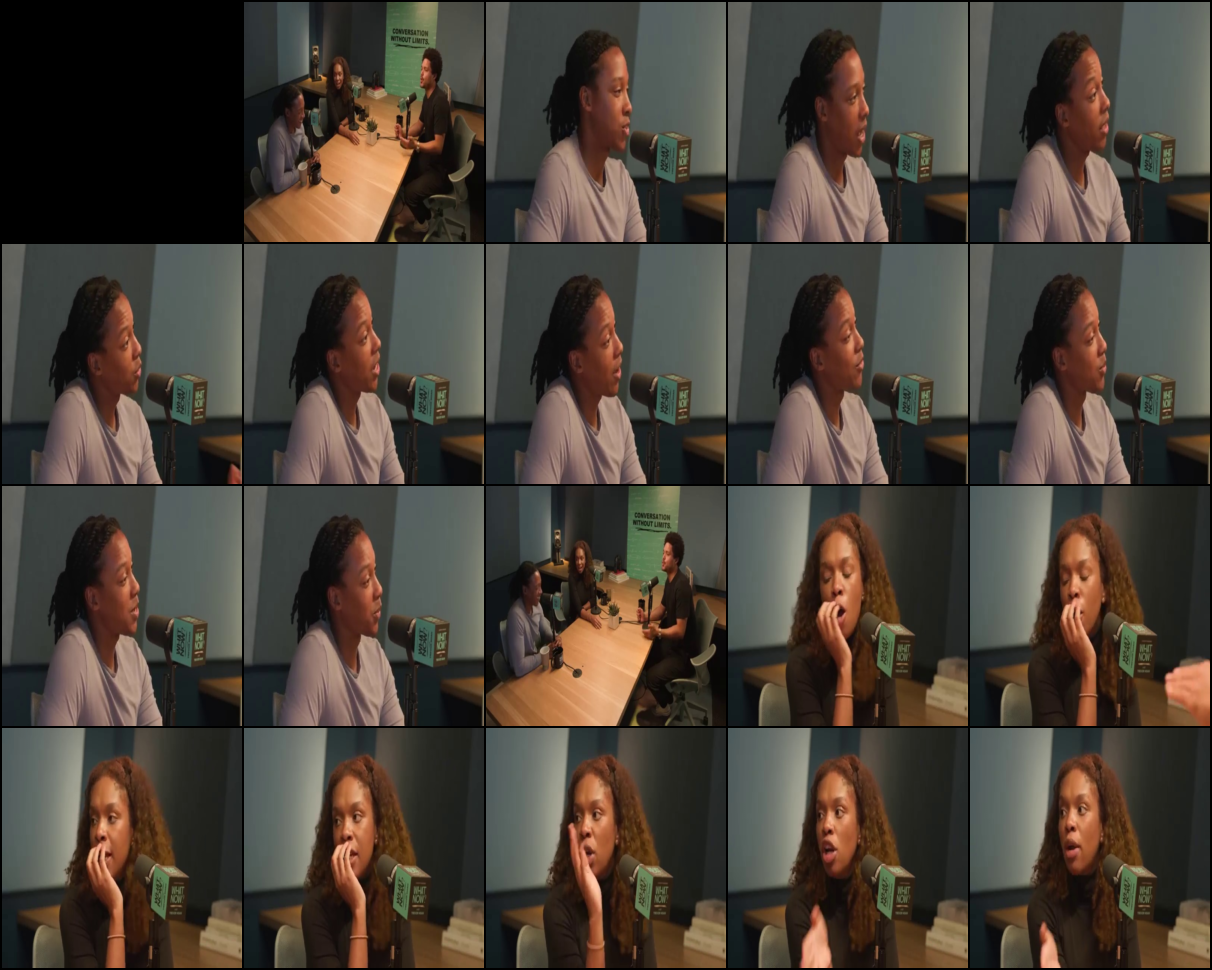

In [15]:
display_sample(frames_dir, sample=20)

### Face detection

In [11]:
# Initialize the mtcnn model from facenet for face detection
mtcnn = MTCNN(device=device, keep_all=True, min_face_size=60, post_process=False)

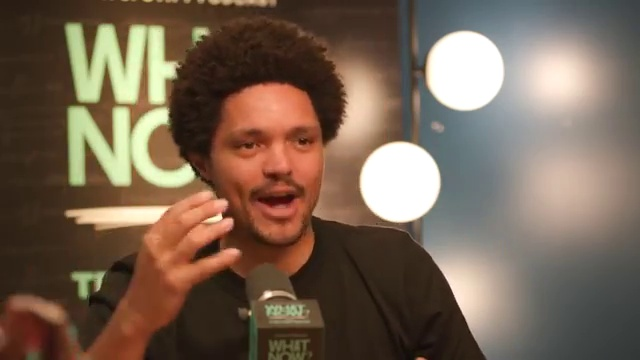

In [19]:
# lets detect the face in a sample image first
sample_image_name = "frame_1312.jpg"

sample_image_path = frames_dir / sample_image_name

sample_image = Image.open(sample_image_path)
sample_image

In [20]:
boxes, probs = mtcnn.detect(sample_image)

In [19]:
print(boxes)
print(boxes.shape)

[[214.1733856201172 85.64493560791016 323.1806640625 236.56912231445312]]
(1, 4)


In [20]:
number_of_detected_faces = len(boxes)

print(number_of_detected_faces)

1


In [21]:
probs

array([0.9998347759246826], dtype=object)

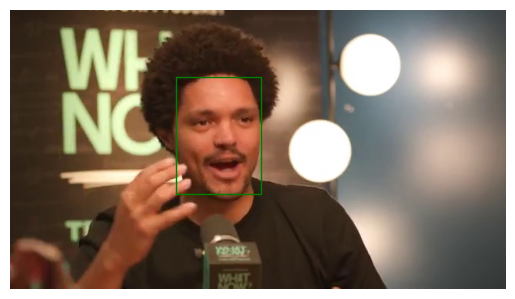

In [22]:
fig, ax = plt.subplots()
ax.imshow(sample_image)

for box in boxes:
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="green"
    )
    ax.add_patch(rect)
plt.axis("off");

In [23]:
# lets also show the face landmarks it detected
boxes, probs, landmarks = mtcnn.detect(sample_image, landmarks=True)

In [24]:
print(landmarks.shape)

(1, 5, 2)


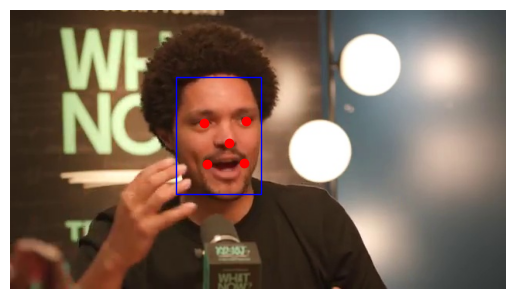

In [25]:
fig, ax = plt.subplots()
ax.imshow(sample_image)

for box, landmark in zip(boxes, landmarks):
    rect = plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="blue"
    )
    ax.add_patch(rect)
    for point in landmark:
        ax.plot(point[0], point[1], marker="o", color="red")
plt.axis("off");

### Prepare a subset of the images for creating the face embeddings

In [26]:
images_dir = Path.cwd() / "data" / "images"

images_dir.mkdir(exist_ok=True)

In [62]:
# Select sample image for the first face
trevor = images_dir/ "trevor"

trevor.mkdir(exist_ok=True)

In [63]:
trevor_img_list = [f"frame_{i}.jpg" for i in range(4, 65, 4)] + [f"frame_{i}.jpg" for i in range(520, 628, 4)]
print(trevor_img_list)

['frame_4.jpg', 'frame_8.jpg', 'frame_12.jpg', 'frame_16.jpg', 'frame_20.jpg', 'frame_24.jpg', 'frame_28.jpg', 'frame_32.jpg', 'frame_36.jpg', 'frame_40.jpg', 'frame_44.jpg', 'frame_48.jpg', 'frame_52.jpg', 'frame_56.jpg', 'frame_60.jpg', 'frame_64.jpg', 'frame_520.jpg', 'frame_524.jpg', 'frame_528.jpg', 'frame_532.jpg', 'frame_536.jpg', 'frame_540.jpg', 'frame_544.jpg', 'frame_548.jpg', 'frame_552.jpg', 'frame_556.jpg', 'frame_560.jpg', 'frame_564.jpg', 'frame_568.jpg', 'frame_572.jpg', 'frame_576.jpg', 'frame_580.jpg', 'frame_584.jpg', 'frame_588.jpg', 'frame_592.jpg', 'frame_596.jpg', 'frame_600.jpg', 'frame_604.jpg', 'frame_608.jpg', 'frame_612.jpg', 'frame_616.jpg', 'frame_620.jpg', 'frame_624.jpg']


In [64]:
trevor_img_path = [Path("data", "extracted_frames")/ img for img in trevor_img_list]

#check the numbers of image in this list
print(len(trevor_img_path))

43


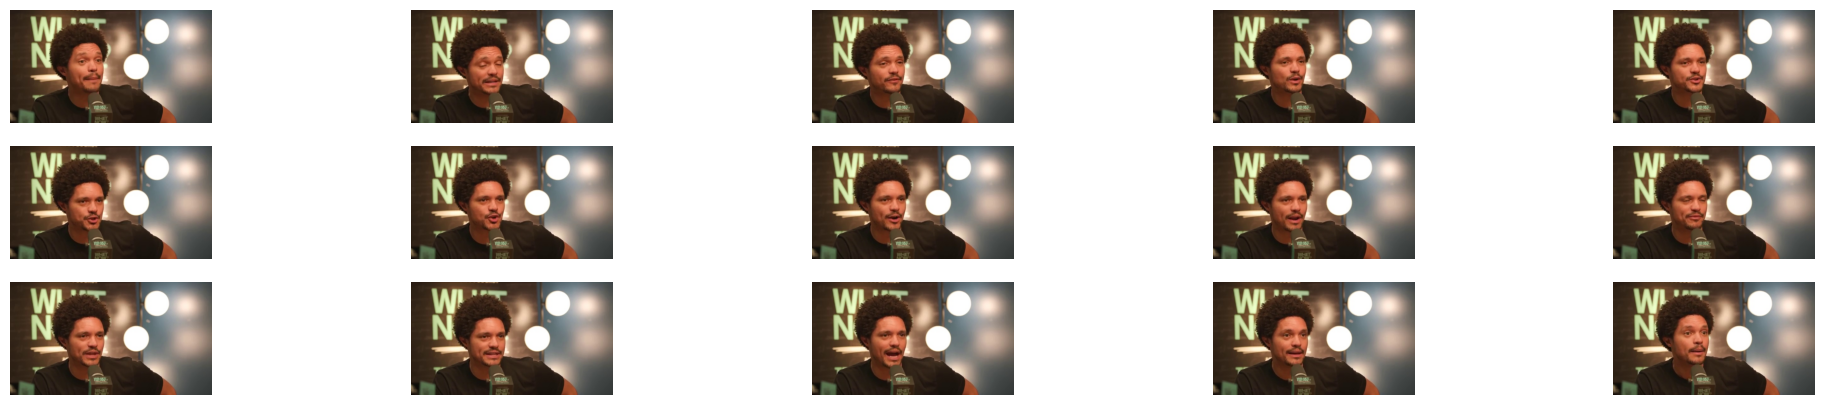

In [61]:
fig, axs = plt.subplots(3, 5, figsize=(25, 5))

axs = axs.ravel()

for i, ax in enumerate(axs):
    ax.imshow(Image.open(trevor_img_path[i]))
    ax.axis("off")

In [65]:
for image_path in trevor_img_path:
    shutil.copy(image_path, trevor)

In [32]:
# select sample image for the second and third face
christiana = images_dir/ "christiana"
josh = images_dir/ "josh"

christiana.mkdir(exist_ok=True)
josh.mkdir(exist_ok=True)

# lets make sure we have the same number of sample image
christiana_img_list = [f"frame_{i}.jpg" for i in range(196, 236, 4)] + [f"frame_{i}.jpg" for i in range(1212, 1268, 4)] +  [f"frame_{i}.jpg" for i in range(640, 668, 4)] + [f"frame_{i}.jpg" for i in range(1064, 1096, 4)] + [f"frame_{i}.jpg" for i in range(1404, 1424, 4)]
josh_img_list = [f"frame_{i}.jpg" for i in range(68, 96, 4)] + [f"frame_{i}.jpg" for i in range(1344, 1372, 4)] + ["frame_1032.jpg", "frame_1000.jpg"] + [f"frame_{i}.jpg" for i in range(768, 840, 4)] + [f"frame_{i}.jpg" for i in range(896, 924, 4)]
print(christiana_img_list)
print(josh_img_list)

christiana_img_path = [Path("data", "extracted_frames")/ img for img in christiana_img_list]
josh_img_path = [Path("data", "extracted_frames")/ img for img in josh_img_list]

['frame_196.jpg', 'frame_200.jpg', 'frame_204.jpg', 'frame_208.jpg', 'frame_212.jpg', 'frame_216.jpg', 'frame_220.jpg', 'frame_224.jpg', 'frame_228.jpg', 'frame_232.jpg', 'frame_1212.jpg', 'frame_1216.jpg', 'frame_1220.jpg', 'frame_1224.jpg', 'frame_1228.jpg', 'frame_1232.jpg', 'frame_1236.jpg', 'frame_1240.jpg', 'frame_1244.jpg', 'frame_1248.jpg', 'frame_1252.jpg', 'frame_1256.jpg', 'frame_1260.jpg', 'frame_1264.jpg', 'frame_640.jpg', 'frame_644.jpg', 'frame_648.jpg', 'frame_652.jpg', 'frame_656.jpg', 'frame_660.jpg', 'frame_664.jpg', 'frame_1064.jpg', 'frame_1068.jpg', 'frame_1072.jpg', 'frame_1076.jpg', 'frame_1080.jpg', 'frame_1084.jpg', 'frame_1088.jpg', 'frame_1092.jpg', 'frame_1404.jpg', 'frame_1408.jpg', 'frame_1412.jpg', 'frame_1416.jpg', 'frame_1420.jpg']
['frame_68.jpg', 'frame_72.jpg', 'frame_76.jpg', 'frame_80.jpg', 'frame_84.jpg', 'frame_88.jpg', 'frame_92.jpg', 'frame_1344.jpg', 'frame_1348.jpg', 'frame_1352.jpg', 'frame_1356.jpg', 'frame_1360.jpg', 'frame_1364.jpg', 'fr

In [33]:
print(len(christiana_img_path))
print(len(josh_img_path))

44
41


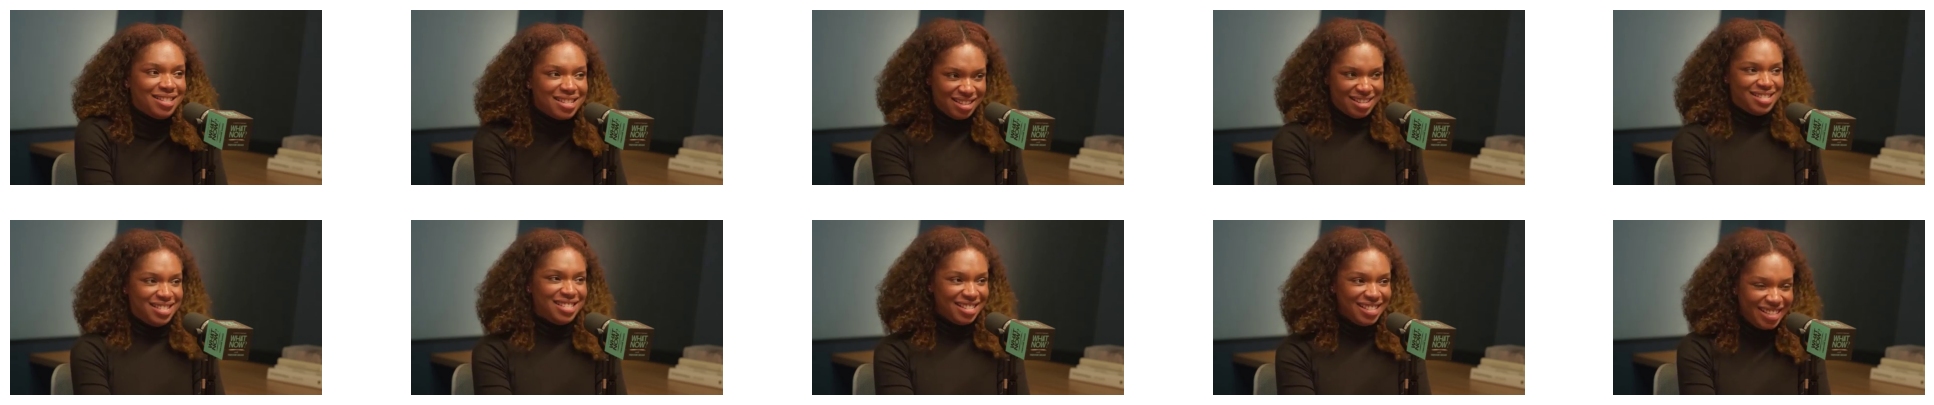

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(25, 5))

axs = axs.ravel()

for i, ax in enumerate(axs):
    ax.imshow(Image.open(christiana_img_path[i]))
    ax.axis("off")

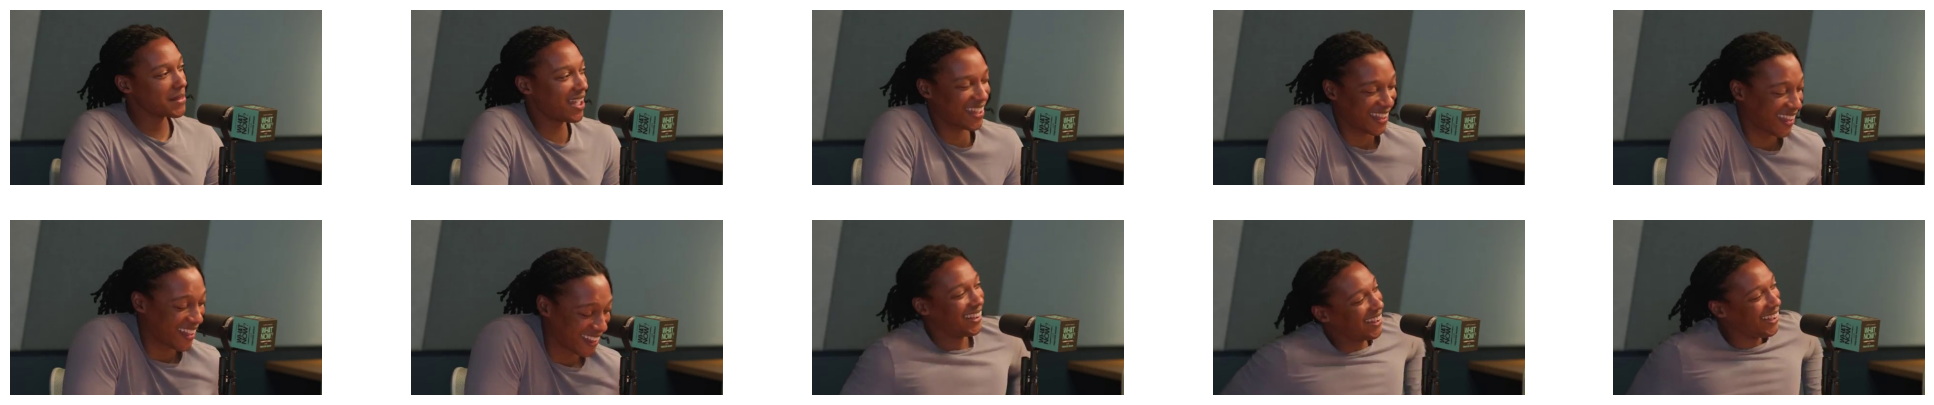

In [35]:
fig, axs = plt.subplots(2, 5, figsize=(25, 5))

axs = axs.ravel()

for i, ax in enumerate(axs):
    ax.imshow(Image.open(josh_img_path[i]))
    ax.axis("off")

In [36]:
# move christiana frame to the images directory
for image_path in christiana_img_path:
    shutil.copy(image_path, christiana)

In [37]:
# move josh frame to the images directory
for image_path in josh_img_path:
    shutil.copy(image_path, josh)

### Face recognition

In [7]:
resnet = InceptionResnetV1(pretrained="vggface2").eval()

In [66]:
# create an imagefolder object from the image directory
dataset = datasets.ImageFolder(images_dir)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 128
    Root location: /root/Computer_vision-1/face_recognition/data/images


In [67]:
dataset.class_to_idx

{'christiana': 0, 'josh': 1, 'trevor': 2}

In [68]:
# we need the reverse mapping for the face recognition
idx_to_class = {label:integer for integer, label in dataset.class_to_idx.items()}

print(idx_to_class)

{0: 'christiana', 1: 'josh', 2: 'trevor'}


In [69]:
def collate_fn(x):
    return x[0]

In [70]:
loader = DataLoader(dataset, collate_fn=collate_fn)

print(loader.dataset)

Dataset ImageFolder
    Number of datapoints: 128
    Root location: /root/Computer_vision-1/face_recognition/data/images


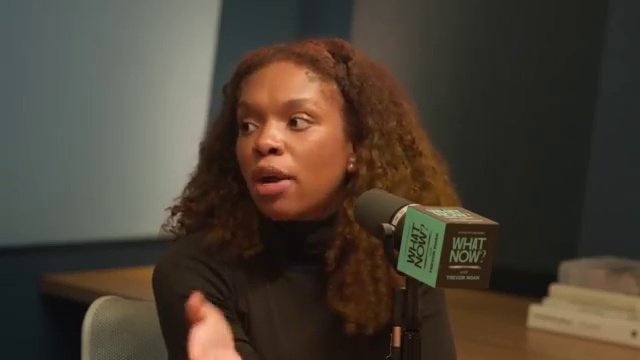

In [71]:
img, _ = next(iter(loader))
img

In [72]:
# detect a single face from the data loader
face, prob = mtcnn(img, return_prob=True)

print(type(face))
print(f"Probability of detected face: {prob}")

<class 'torch.Tensor'>
Probability of detected face: [1.0]


In [73]:
# create a dictionary that map each name to their respective embedding
name_to_embeddings = {name: [] for name in idx_to_class.values()}

for img, idx in loader:
    face, prob = mtcnn(img, return_prob=True)
    if face is not None and prob[0] > 0.9:
        emb = resnet(face)
        name_to_embeddings[idx_to_class[idx]].append(emb)

In [74]:
name_to_embeddings.keys()

dict_keys(['christiana', 'josh', 'trevor'])

In [75]:
# create a 2d vector of the embeddings
embeddings_christiana = torch.stack(name_to_embeddings["christiana"])
embeddings_josh = torch.stack(name_to_embeddings["josh"])
embeddings_trevor = torch.stack(name_to_embeddings["trevor"])

embeddings_christiana_shape = embeddings_christiana.shape
embeddings_josh_shape = embeddings_josh.shape
embeddings_trevor_shape = embeddings_trevor.shape

print(f"Shape of embedding for Chritiana: {embeddings_christiana_shape}")
print(f"Shape of embedding for Josh: {embeddings_josh_shape}")
print(f"Shape of embedding for chritiana: {embeddings_trevor_shape}")

Shape of embedding for Chritiana: torch.Size([44, 1, 512])
Shape of embedding for Josh: torch.Size([41, 1, 512])
Shape of embedding for chritiana: torch.Size([43, 1, 512])


In [76]:
# calculate the mean of each embedding along the dim=0
christiana_embedding_mean = embeddings_christiana.mean(dim=0)
josh_embedding_mean = embeddings_josh.mean(dim=0)
trevor_embedding_mean = embeddings_trevor.mean(dim=0)

In [77]:
# check the shape of the mean embedding
christiana_embedding_mean.shape

torch.Size([1, 512])

In [78]:
# save the embedding
embeddings_to_save = [
    (christiana_embedding_mean, "christiana"),
    (josh_embedding_mean, "josh"),
    (trevor_embedding_mean, "trevor")
]

torch.save(embeddings_to_save, "embeddings.pt")

In [21]:
# load the embedding data
embedding_data = torch.load("embeddings.pt")

for _, name in embedding_data:
    print(name)

christiana
josh
trevor


In [25]:
def recognize_faces_in_video(video_path, output_path, embedding_data, mtcnn, resnet, threshold=0.7):
    """
    Recognize faces in a video and output a labeled video.

    Args:
        video_path (str): Path to the input video file.
        output_path (str): Path to save the output labeled video.
        embedding_data (list): List of tuples (embedding, name) for known faces.
        mtcnn: MTCNN face detector.
        resnet: Face recognition model.
        threshold (float): Distance threshold for recognition.
    """
    # Open the input video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video

    # Create a VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        frame_idx += 1
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert frame to RGB
        image = Image.fromarray(rgb_frame)

        # Detect faces and generate cropped tensors
        boxes, probs = mtcnn.detect(image)
        cropped_images = mtcnn(image)

        if boxes is not None:
            for box, prob, face in zip(boxes, probs, cropped_images):
                if prob < 0.90:
                    continue

                # Compare against known embeddings
                emb = resnet(face.unsqueeze(0))
                distances = {}
                for known_emb, name in embedding_data:
                    dist = torch.dist(emb, known_emb).item()
                    distances[name] = dist

                # Find the closest match
                closest, min_dist = min(distances.items(), key=lambda x: x[1])

                # Determine the label
                name = closest if min_dist < threshold else "Unrecognized"
                color = (0, 0, 255) if name == "Unrecognized" else (255, 0, 0)
                label = f"{name} {min_dist:.2f}"

                # Draw bounding box and label on the frame
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(
                    frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2
                )

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()
    print(f"Labeled video saved at {output_path}")


In [24]:
recognize_faces_in_video(output_file, "final_result.mp4", embedding_data, mtcnn, resnet)

Labeled video saved at final_result.mp4
